In [1]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import tensorflow as tf

if os.getcwd().split(os.sep)[-1] == 'notebook':
    os.chdir('..')

from cma import CMA
from notebook.utils import (
    plot_3d_surface,
    plot_2d_contour,
    plot_generations,
    draw_confidence_ellipse,
    plot_mean_coordinates,
)

In [2]:
tf.random.set_seed(444)  # set random seed for reproducibility

# Optimisation of the Six-Hump Camel Function

Using the Covariance Matrix Adaptation Evolution Strategy (CMA-ES)

## 1. Define & visualize the fitness function

The CMA class expects fitness functions with the following signature:

    
    Args:
      x: tf.Tensor of shape (M, N)
    
    Returns:
      Fitness evaluations: tf.Tensor of shape (M,)

Where `M` is the number of solutions to evaluate and `N` is the dimension of a single solution.

In [3]:
def fitness_fn(x):
    """
    Six-Hump Camel Function
    https://www.sfu.ca/~ssurjano/camel6.html
    """
    return (
        (4 - 2.1 * x[:,0]**2 + x[:,0]**4 / 3) * x[:,0]**2 +
        x[:,0] * x[:,1] +
        (-4 + 4 * x[:,1]**2) * x[:,1]**2
    )

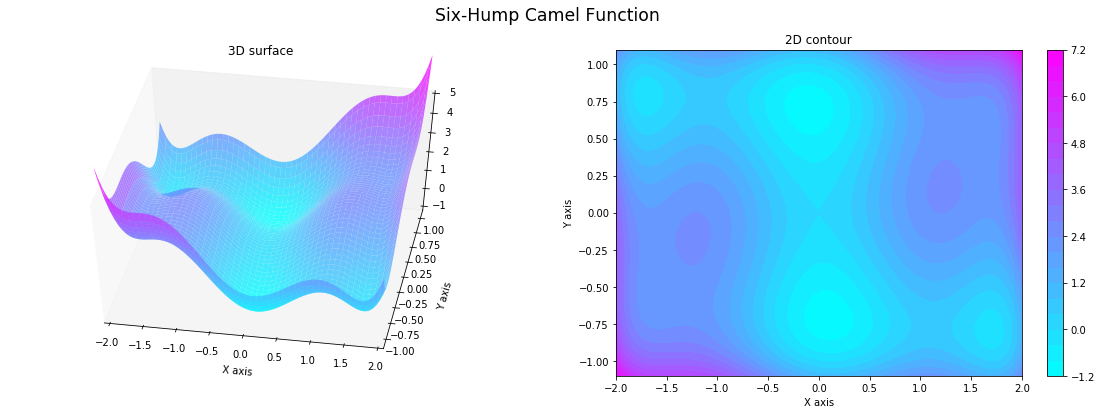

In [4]:
fig = plt.figure(figsize=(20, 6))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0], projection='3d')
ax2 = fig.add_subplot(gs[0,1])

plot_3d_surface(
    fitness_fn,
    xlim=[-2, 2], 
    ylim=[-1.1, 1.1],
    zlim=[-1.1, 5],
    view_init=[50, -80],
    fig=fig,
    ax=ax1,
);
ax1.set_xlabel('\nX axis');
ax1.set_ylabel('\n\nY axis');
ax1.set_title('3D surface\n');

plot_2d_contour(
    fitness_fn,
    xlim=[-2, 2], 
    ylim=[-1.1, 1.1],
    fig=fig,
    ax=ax2,
);
ax2.set_title('2D contour');
fig.patch.set_facecolor('white');
fig.suptitle('Six-Hump Camel Function\n', fontsize='xx-large');

The global minimum value is `-1.0316` at `x = [0.0898, -0.7126]` and `x = [-0.0898, 0.7126]`.

## 2. Configure CMA-ES & run the search

The initial solution and initial step size (i.e. initial standard deviation of the search distribution) are problem specific.

We are setting the `store_trace` parameter to `True` in order to keep track of the key variables at each generation. This will be useful to visualize the search after completion.

In [5]:
cma = CMA(
    initial_solution=[1.5, -0.4],
    initial_step_size=1.0,
    fitness_function=fitness_fn,
    store_trace=True,
)

The search method runs until the maximum number of generation is reached or until one of the early termination criteria is met.

The default maximum number of generations is 500.

In [6]:
%%time
best_solution, best_fitness = cma.search()

print('Number of generations:', cma.generation)
print(f'Best solution: [{best_solution[0]:.5f}, {best_solution[1]:.5f}]')
print(f'Best fitness: {best_fitness:.4f}')
print()

Number of generations: 53
Best solution: [-0.08984, 0.71266]
Best fitness: -1.0316

CPU times: user 1.25 s, sys: 21.5 ms, total: 1.27 s
Wall time: 1.41 s


The search ran for 54 generations before settling down for the global minimum at `[0.0898 -0.7126]`.

## 3. Visualize the search trace

### 3.1 Evolution of the best solution coordinates

In [7]:
sns.set(palette='colorblind', font_scale=1.2)  # better default style for matplotlib

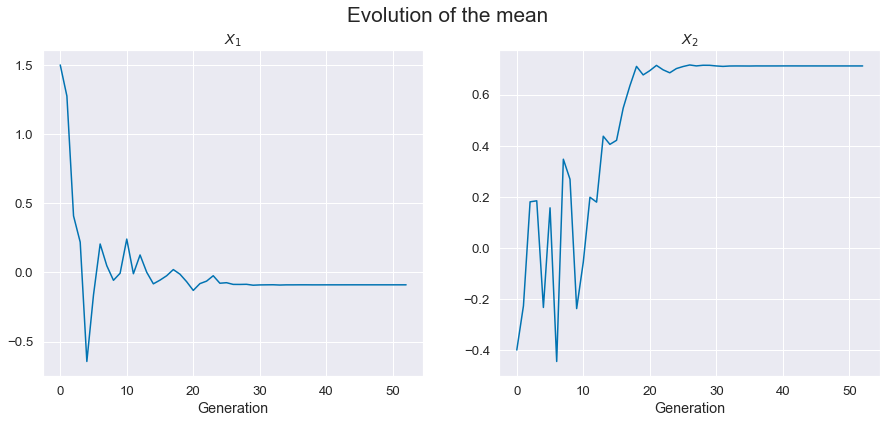

In [8]:
plot_mean_coordinates(cma.trace);

The mean started to converge around generation 25. Early stopping rules kicked in a few generations later.

### 3.2 Plot a few generations

- The cross represents the mean (i.e. best solution at current generation)
- The white dots with border are the sampled solution with best fitness. They'll be used to update the mean and covariance matrix.
- The white dots without border are the worst sample solutions, which are discarded.
- The ellipse is the 2-σ confidence, i.e. 95% of the sampled points will fall within the ellipse.

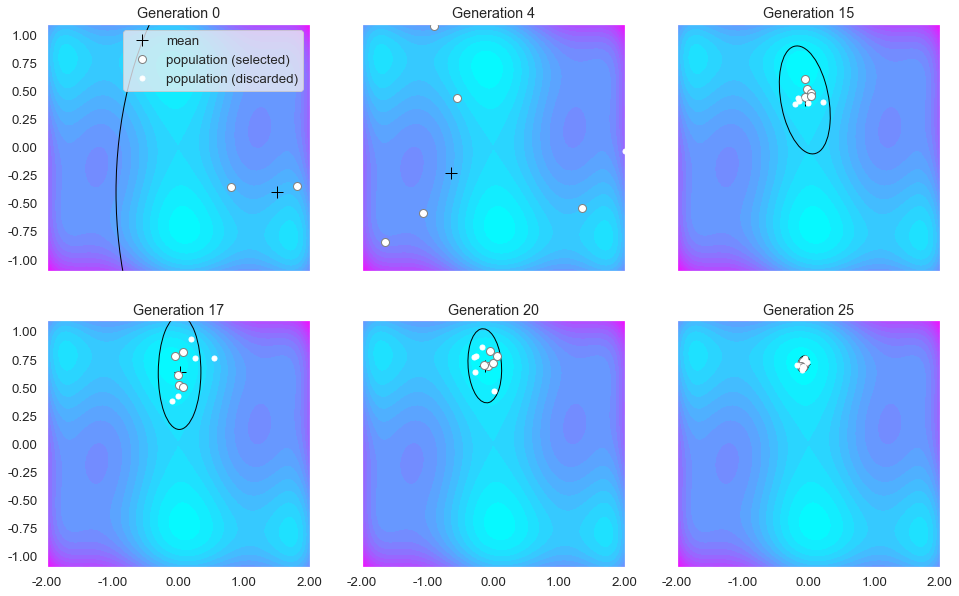

In [9]:
generations = [0, 4, 15, 17, 20, 25]
fig, _ = plot_generations(
    generations,
    cma.trace,
    fitness_fn,
    xlim=[-2, 2], 
    ylim=[-1.1, 1.1],
);